# Setting up

In [1]:
!pip install emoji

In [2]:
!pip install nltk

In [3]:
!pip install --upgrade nltk

In [4]:
!pip install jieba

In [5]:
!pip install indoNLP

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import jieba
import string
import emoji
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from nltk.tokenize import word_tokenize
from indoNLP.preprocessing import replace_slang
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from snowballstemmer import stemmer

# Dataset

## Original

### Train Dataset

In [7]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/multilingual-hatespeech-dataset/Dataset/Training/MultiLanguageTrainDataset.csv
/kaggle/input/multilingual-hatespeech-dataset/Dataset/Testing/Test2/MangolianTranslatedHateSpeech.csv
/kaggle/input/multilingual-hatespeech-dataset/Dataset/Testing/Test2/IrishTranslatedHateSpeech.csv
/kaggle/input/multilingual-hatespeech-dataset/Dataset/Testing/Test2/HindiTranslatedHateSpeech.csv
/kaggle/input/multilingual-hatespeech-dataset/Dataset/Testing/Test2/PersianTranslatedHateSpeech.csv
/kaggle/input/multilingual-hatespeech-dataset/Dataset/Testing/Test2/UrduTranslatedHateSpeech.csv
/kaggle/input/multilingual-hatespeech-dataset/Dataset/Testing/Test2/GeorgianTranslatedHateSpeech.csv
/kaggle/input/multilingual-hatespeech-dataset/Dataset/Testing/TestEmbedded2/MangolianLASERWordEmbeddings.csv
/kaggle/input/multilingual-hatespeech-dataset/Dataset/Testing/TestEmbedded2/IrishLASERWordEmbeddings.csv
/kaggle/input/multilingual-hatespeech-dataset/Dataset/Testing/TestEmbedded2/GeorgianLASERWordEmbe

In [8]:
# load dataset
# train_path = "/content/Dataset/Training/MultiLanguageTrainDataset.csv"
train_path = "/kaggle/input/multilingual-hatespeech-dataset/Dataset/Training/MultiLanguageTrainDataset.csv"
print('==> Loading the dataset...')
hate_S = pd.read_csv(train_path, na_values = ['unknown', ' '], index_col=0)
print('Load successfully!!\n')
hate_S

==> Loading the dataset...
Load successfully!!



,text,label,language
0,لك من جهة ان شاء بضل حرقة بقلبك وبلاطه ع صدرك ...,0.0,1
1,انجاز جديد للعهدجبران باسيل,0.0,1
2,قلبه كبير وئام وديموقراطي عكس باسيل هههه,0.0,1
3,ولك العما بقلبك عمي يا اوطى مخلوق عوج الارض رو...,1.0,1
4,يسعد صباحك يا قائد,0.0,1
...,...,...,...
219976,USER potong gaji dan fasilitas DPR aja yg 500a...,0.0,13
219977,"Kalian boleh tanya padaku ""kapan rabi?"", tapi ...",0.0,13
219978,Satu persatu akhirnya smua ditumbangkan oleh T...,0.0,13
219979,"USER + itu ga pernah solat, ga pernah ngaji, g...",0.0,13


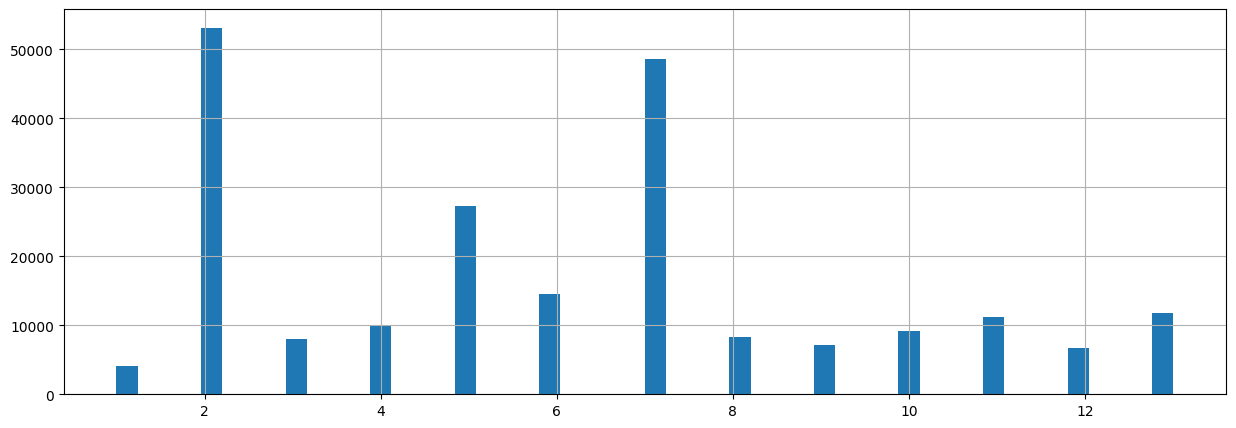

In [9]:
hate_S.language.hist(bins = 50, figsize = (15, 5))
plt.show()

Choose the languages for training

In [10]:
# 1: Arabic
# 4: French
# 5: German
# 6: Russian
# 7: Turkish
# 8: Roman Hindi/ Urdu
# 9: Korean
# 10: Italian
# 11: Spanish
# 12: Portuguese

# Drop away chinese and indonesian
lang_list = [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
hate_S.drop(hate_S[hate_S.language.isin(lang_list)].index, axis=0, inplace=True)
hate_S.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53146 entries, 4161 to 57306
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   text      53146 non-null  object 
 1   label     53146 non-null  float64
 2   language  53146 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.6+ MB


In [11]:
# Translation for Chinese Text
zh_path ='/kaggle/input/translation-and-back-translation/zh_hate_translations.csv'
zh_hate= pd.read_csv(zh_path, na_values = ['unknown', ' '], index_col=0)
zh_nonhate = pd.read_csv('/kaggle/input/translation-and-back-translation/zh_nonhate_translations.csv', index_col=0)
zh_translation = pd.concat([zh_hate,zh_nonhate], axis=0)


zh_hate

,text,label,language,translated_text,back_translated_text
Unnamed: 0,,,,,
57307,这么怕女性侵占你的权益那求求你别结婚别谈恋爱了，少祸害一个是一个,1.0,3,If you are so afraid that women will encroach ...,如果你很害怕女人侵犯你的权利，请不要结婚和恋爱。不要一一伤害。
57319,4.有趣的是，这位男士的第一反应是「啊，又有妖孽来害朕」，而对这次运动中被暴露（实则早已心知...,1.0,3,4. What’s interesting is that this man’s first...,4. 有趣的是，这个男人的第一反应是“啊，又一个怪物来伤害我了”，但他对这次运动中暴露女性的...
57322,婚驴对女性的敏感点极高，在男人面前就跟死猪一样,1.0,3,Marriage donkeys are extremely sensitive to wo...,婚姻驴对女人极其敏感，在男人面前就像死猪一样。
57325,他们骂男人因为她们就是想和男人结婚啊，不想结婚男人就是路人，他糟糕成什么样，有关系么？,1.0,3,They scold men because they just want to marry...,她们骂男人是因为她们只想嫁给男人。不想结婚的男人只是过客。他有多坏还有关系吗？
57327,就是呀，从量上一直就是女的被这条法律坑的多，好不容易出个女的能用这条去恶心男的，高兴都来不及...,1.0,3,That’s right. Women have always been cheated m...,这是正确的。女性总是被这条法律欺骗得更多。很难找到一个女人能够利用这条法律来恶心男人。高兴的...
...,...,...,...,...,...
65360,做男人好难，天天被这些三观正的女性“作家”扣帽子,1.0,3,"It’s hard to be a man, and I’m criticized ever...",做男人真不容易，每天都被这些乐观人生观的女“作家”批评。
65361,不就是执法机构管不了 才让网友管么 而且微博女权师不是战斗力惊人么 和那些村里老男人撕逼不正合适么,1.0,3,Isn’t it because law enforcement agencies can’...,不是因为执法部门管不了才让网友来管吗？而且微博女权的战斗力不是很惊人吗？跟村里那些老头子打架...
65363,当女权在讨论冠姓权，指出强势高阶女婚内也失权，感叹婚内普女更不容易顺便反婚，但是婚驴只看到了...,1.0,3,When women's rights are discussing the right t...,当女权在讨论姓氏使用权时，她们指出有权势的高位女性失去了婚内权利，感叹普通女性在婚内反抗婚姻...


In [12]:
# Translation for Indonesian Text
id_hate = pd.read_csv('/kaggle/input/translation-and-back-translation/id_hate_translations.csv', index_col=0)
id_nonhate = pd.read_csv('/kaggle/input/translation-and-back-translation/id_nonhate_translations.csv', index_col=0)
id_translation = pd.concat([id_hate,id_nonhate], axis=0)

id_translation

,text,label,language,translated_text,back_translated_text
Unnamed: 0,,,,,
208129,Sebenernya pacar gue itu 12 idiot :*',1.0,13,Actually my boyfriend is 12 idiots :*',Sebenarnya pacarku 12 idiot :*'
208130,98. Sebenernya gw ogah temenan ama lu di rl rp...,1.0,13,"98. Actually, I don't want to be friends with ...",98. Sebenarnya aku tidak ingin berteman dengan...
208133,USER Mahasiswa koplak...cuma modus..!!! Rakyat...,1.0,13,USER Student coplak...just a mod..!!! The Indo...,USER Mahasiswa coplak...hanya mod..!!! Rakyat ...
208134,USER Ulama cebong... Wajah suram',1.0,13,USER Tadpole cleric... Gloomy face',Ulama Kecebong PENGGUNA... Wajah muram'
208135,USER USER Yang bijak cuma petugas dan jajaran ...,1.0,13,USER USER The wise ones are only the train off...,USER USER Yang bijak hanya petugas dan staf ke...
...,...,...,...,...,...
219976,USER potong gaji dan fasilitas DPR aja yg 500a...,0.0,13,USER just cut the salaries and facilities of t...,USER baru saja memotong gaji dan fasilitas DPR...
219977,"Kalian boleh tanya padaku ""kapan rabi?"", tapi ...",0.0,13,"You can ask me ""when Rabbi?"", but don't ask me...","Anda bisa bertanya kepada saya ""kapan Rabi?"", ..."
219978,Satu persatu akhirnya smua ditumbangkan oleh T...,0.0,13,"One by one, all of them were finally overthrow...","Satu demi satu, semuanya akhirnya ditumbangkan..."


In [13]:
# Choose the translated text only

zh_translation['text']=zh_translation['translated_text']
zh_dataset=zh_translation.drop(columns=['translated_text','back_translated_text'])

id_translation['text'] = id_translation['translated_text']
id_dataset = id_translation.drop(columns=['translated_text','back_translated_text'])

translated = pd.concat([zh_translation,id_translation], axis=0)

In [14]:
# Concat the English set and the translated set
hate_S = pd.concat([hate_S, translated],axis=0)

# Drop the columns
hate_S = hate_S[hate_S['text']!='ERROR']
hate_S = hate_S.drop(columns=['language','translated_text','back_translated_text'])
hate_S

,text,label
4161,South Africa Charges 4 Suspected of Plotting t...,0.0
4162,terrorist leftist,1.0
4163,RT HanzalaOfficial: India your link with ISIS ...,0.0
4164,Seize Pope & Rothschild who owns Fed Reserve ...,0.0
4165,Saudi-led bombing in Yemen; ISIS abuses; Turke...,0.0
...,...,...
219976,USER just cut the salaries and facilities of t...,0.0
219977,"You can ask me ""when Rabbi?"", but don't ask me...",0.0
219978,"One by one, all of them were finally overthrow...",0.0
219979,"USER + never prays, never reads the Koran, nev...",0.0


### Validation Dataset

In [15]:
def split_validation(dataframe):
    
    #Split 30% for every language
    train_df, val_df = train_test_split(dataframe, test_size=0.3, random_state=42)    
    return train_df, val_df

In [16]:
trainset, val_set = split_validation(hate_S)

In [17]:
print(f"Total data points: {len(hate_S)}")
print(f"Training set size: {len(trainset)} ({len(trainset)/len(hate_S)*100:.2f}%)")
print(f"Validation set size: {len(val_set)} ({len(val_set)/len(hate_S)*100:.2f}%)")

Total data points: 73049
Training set size: 51134 (70.00%)
Validation set size: 21915 (30.00%)


## Test Dataset

In [18]:
# Test
en_path = "/kaggle/input/multilingual-hatespeech-dataset/Dataset/Testing/Test1/English_test.csv"
en_test = pd.read_csv(en_path, na_values = ['unknown', ' '], index_col=0)

zh_path = "/kaggle/input/translation-and-back-translation/zh_test_translations.csv"
zh_test = pd.read_csv(zh_path, na_values = ['unknown', ' '], index_col=0)
zh_test['text']=zh_test['translated_text']
zh_test=zh_test.drop(columns=['translated_text','back_translated_text'])

id_path = "/kaggle/input/translation-and-back-translation/id_test_translations.csv"
id_test = pd.read_csv(id_path, na_values = ['unknown', ' '], index_col=0)
id_test['text']=id_test['translated_text']
id_test=id_test.drop(columns=['translated_text','back_translated_text'])

In [19]:
testset = pd.concat([en_test, zh_test, id_test])
testset=testset[testset['text']!='ERROR']
testset.shape

(8048, 2)

# Dataset Overview

In [20]:
# Info of trainset
trainset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51134 entries, 211160 to 19956
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   text    51134 non-null  object 
 1   label   51134 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.2+ MB


In [21]:
# Info of val_set
val_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21915 entries, 62610 to 49797
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   text    21915 non-null  object 
 1   label   21915 non-null  float64
dtypes: float64(1), object(1)
memory usage: 513.6+ KB


In [22]:
# Info of testset
testset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8048 entries, 141059 to 242896
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   text    8048 non-null   object 
 1   label   8048 non-null   float64
dtypes: float64(1), object(1)
memory usage: 188.6+ KB


## Overview on label in each language

### Trainset

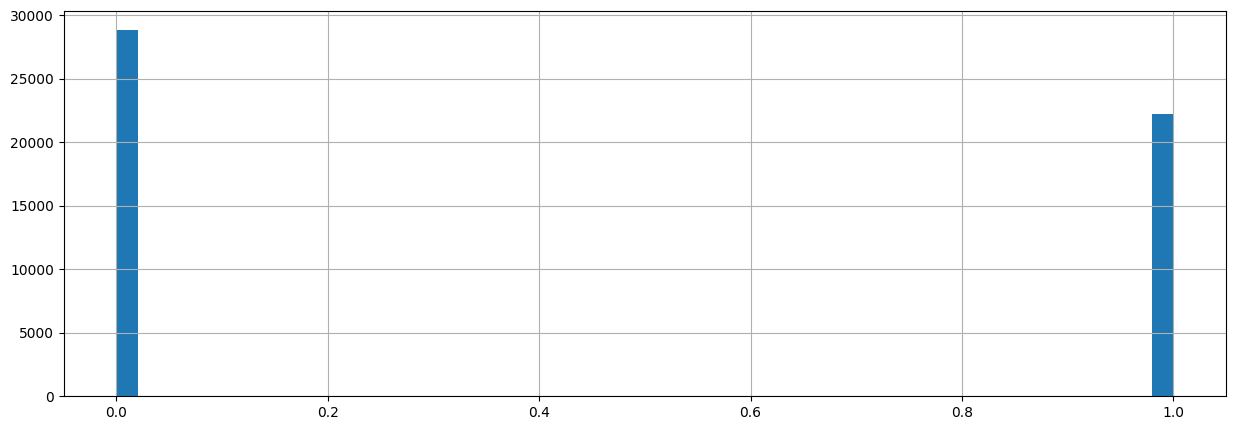

In [23]:
trainset.label.hist(bins = 50, figsize = (15, 5))
plt.show()

In [24]:
counts_train = trainset['label'].value_counts()
print(counts_train)

label
0.0    28888
1.0    22246
Name: count, dtype: int64


### Validation Set

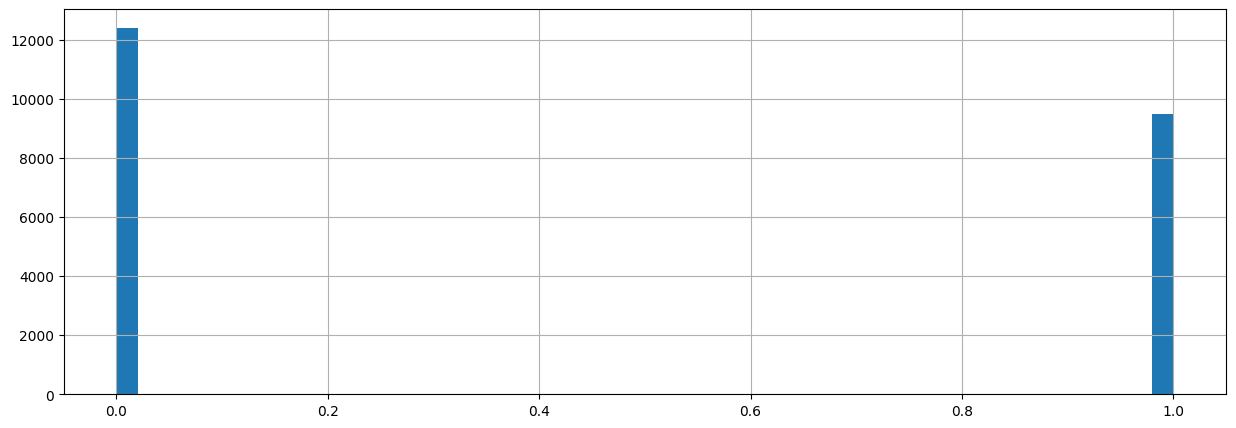

In [25]:
val_set.label.hist(bins = 50, figsize = (15, 5))
plt.show()

In [26]:
counts_val = val_set['label'].value_counts()
print(counts_val)

label
0.0    12415
1.0     9500
Name: count, dtype: int64


### Testset

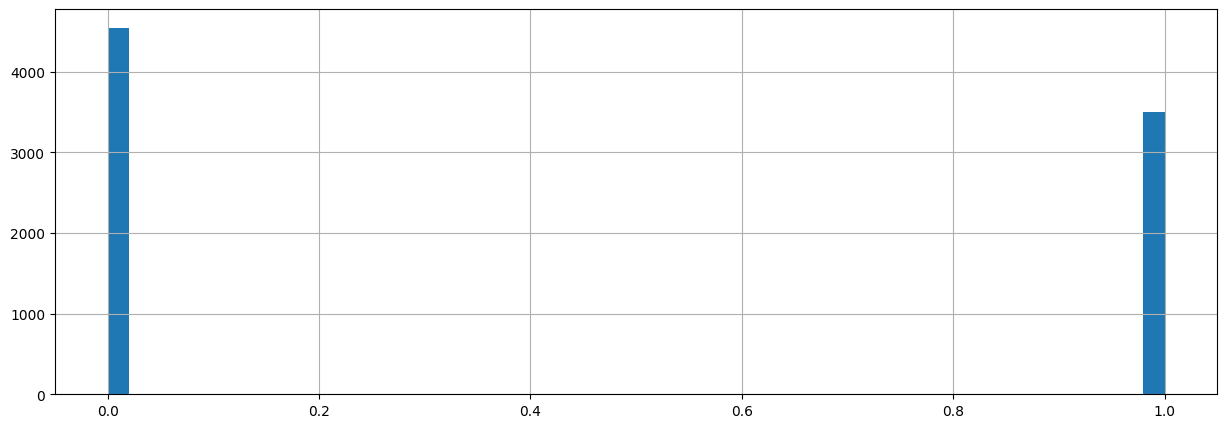

In [27]:
testset.label.hist(bins = 50, figsize = (15, 5))
plt.show()

In [28]:
counts_test = testset['label'].value_counts()
print(counts_test)

label
0.0    4547
1.0    3501
Name: count, dtype: int64


# Undersampling

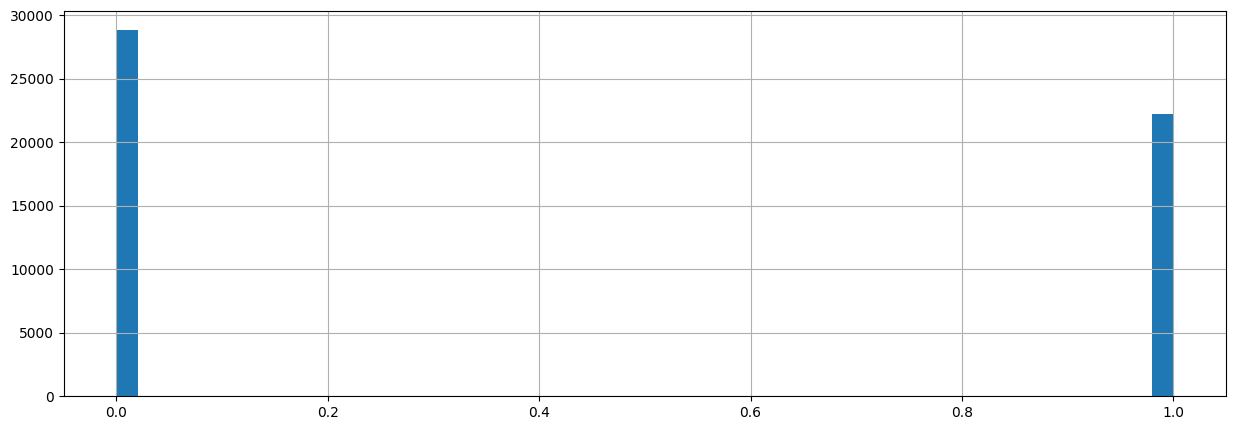

In [29]:
trainset.label.hist(bins = 50, figsize = (15, 5))
plt.show()

In [30]:
counts_train = trainset['label'].value_counts()
print(counts_train)

label
0.0    28888
1.0    22246
Name: count, dtype: int64


In [31]:
def undersample(dataframe, sampling_strategy='auto', random_state=42):
    # Error handling for required columns
    if 'text' not in dataframe.columns or 'label' not in dataframe.columns:
        raise ValueError("DataFrame must contain 'text' and 'label' columns.")

    # Initialize the undersampler
    undersampler = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=random_state)

    # Extract text and label columns and any other relevant columns
    feature_columns = [col for col in dataframe.columns if col != 'label']  # Assuming 'label' is the only target column
    X = dataframe[feature_columns]
    y = dataframe['label']

    # Perform random undersampling
    X_resampled, y_resampled = undersampler.fit_resample(X, y)

    # Create a new DataFrame for the undersampled data
    undersampled_df = pd.DataFrame(X_resampled, columns=feature_columns)
    undersampled_df['label'] = y_resampled

    return undersampled_df

In [32]:
def undersampling(dataframe):
    
    undersampled_df = undersample(dataframe)
    
    return undersampled_df

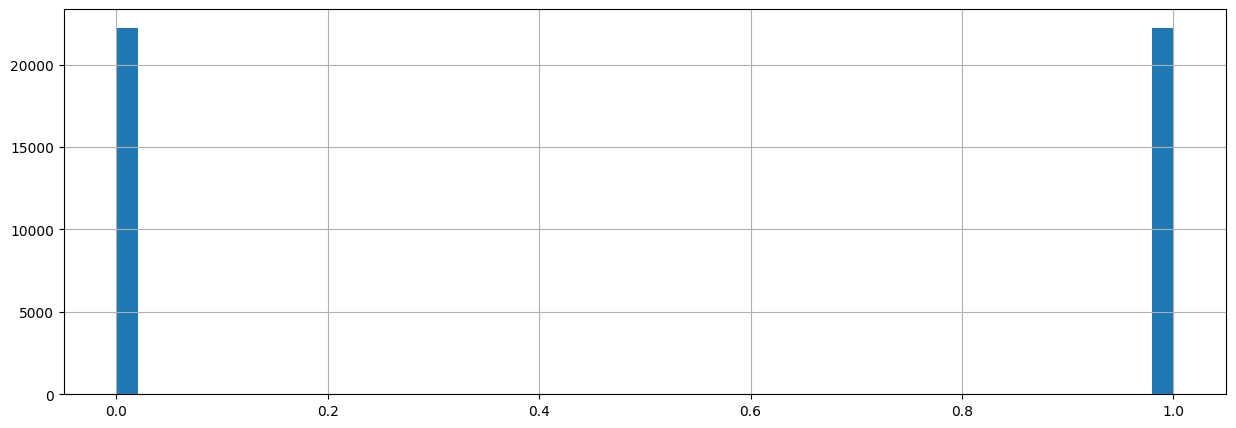

In [33]:
undersampled_trainset = undersampling(trainset)

undersampled_trainset.label.hist(bins = 50, figsize = (15, 5))
plt.show()

In [34]:
counts_under = undersampled_trainset['label'].value_counts()
print(counts_under)

label
0.0    22246
1.0    22246
Name: count, dtype: int64


# Preprocessing

## Preprocessing English

In [35]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [36]:
# abbreviation list taken from https://www.kaggle.com/code/nmaguette/up-to-date-list-of-slangs-for-text-preprocessing#Slangs
# English Abbreviation
abbreviations = {
    "$": " dollar ",
    "€": " euro ",
    "4ao": "for adults only",
    "a.m": "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk",
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart",
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "pls" : "please",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet",
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously",
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [37]:
class EnTextCleaner:
    def __init__(self, dataframe, abbreviations):
        self.dataframe = dataframe.copy()
        self.abbreviations = abbreviations

    def lower_casing(self):
        """Convert all text to lowercase."""
        self.dataframe.loc[:, 'cleaned_text'] = self.dataframe["text"].str.lower()
        return self

    def remove_urls(self):
        """Remove urls."""
        url_re = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
        self.dataframe.loc[:, 'cleaned_text'] = self.dataframe["cleaned_text"].apply(lambda text: url_re.sub('', text))
        return self

    def remove_usernames(self):
        """Remove usernames that start with '@'."""
        self.dataframe.loc[:, 'cleaned_text'] = self.dataframe['cleaned_text'].apply(lambda text: re.sub('@[^\s]+', '', text))
        return self

    def remove_html(self):
        """Remove HTML tags."""
        tag_re = re.compile(r'<[^>]+>')
        self.dataframe.loc[:, 'cleaned_text'] = self.dataframe['cleaned_text'].apply(lambda text: tag_re.sub('', text))
        return self

    def remove_hex_and_unicode(self):  #found in indonesian
        """Remove hexadecimal and Unicode escape sequences."""
        self.dataframe.loc[:, 'cleaned_text'] = self.dataframe['cleaned_text'].apply(
            lambda text: re.sub(r'\\x[0-9a-fA-F]+|\\u[0-9a-fA-F]{4}', '', text))
        return self

    def remove_emoji(self):
        """Remove emoji from text"""
        self.dataframe.loc[:, 'cleaned_text'] = self.dataframe['cleaned_text'].apply(lambda text: emoji.replace_emoji(text))
        return self

    def remove_punctuation(self):
        """Remove punctuation from the text, including Chinese punctuation if specified."""
        en_punct_pattern = re.compile('[{}]'.format(re.escape(string.punctuation)))
        self.dataframe.loc[:, 'cleaned_text'] = self.dataframe['cleaned_text'].apply(lambda text: en_punct_pattern.sub('', text))
        return self

    def remove_numbers(self):
        """Remove numbers"""
        self.dataframe.loc[:, 'cleaned_text'] = self.dataframe['cleaned_text'].apply(lambda text: re.sub('\d+', '', text))
        return self

    def remove_whitespace(self):
        """Remove whitespaces"""
        self.dataframe.loc[:, 'cleaned_text'] = self.dataframe['cleaned_text'].apply(lambda text: " ".join(text.split()))
        return self

    def chat_word_conversion(self):
        """Convert chat words into formal words"""
        def convert_abbrev(text):
            #tokenize the text first
            tokens = word_tokenize(text)
            converted_tokens = [self.abbreviations.get(token.lower(), token) for token in tokens]
            return ' ' .join(converted_tokens)

        self.dataframe.loc[:, 'cleaned_text'] = self.dataframe['cleaned_text'].apply(convert_abbrev)
        return self

    def remove_en_stopwords(self):
        """Remove stopwords"""
        def remove_stopwords(text):
            tokens = word_tokenize(text)
            english_stopwords = set(stopwords.words('english')) | {"retweet", "user"}
            removed_tokens = [token for token in tokens if token not in english_stopwords]
            return ' ' .join(removed_tokens)

        self.dataframe.loc[:, 'cleaned_text'] = self.dataframe['cleaned_text'].apply(remove_stopwords)
        return self

    def en_lemmatizer(self):
        """Lemmatize English"""

        def lemmatize_words(text):
            """Function to lemmatize words in a list of tokens"""
            lemmatizer = WordNetLemmatizer()
            wordnet_map = {
                'N': wordnet.NOUN,
                'V': wordnet.VERB,
                'R': wordnet.ADV,
                'J': wordnet.ADJ
            }

            tokens = word_tokenize(text)

            # Perform part-of-speech tagging
            pos_tagged_tokens = nltk.pos_tag(tokens)
            # Lemmatize each word based on its part-of-speech
            lemmatized_tokens = [lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_tokens]
            return ' ' .join(lemmatized_tokens)

        self.dataframe.loc[:, 'cleaned_text'] = self.dataframe['cleaned_text'].apply(lemmatize_words)
        return self

    def get_cleaned_dataframe(self):
        """Return the cleaned DataFrame."""
        return self.dataframe

## Preprocessing Indosnesian

## Preprocessed Dataframe

In [43]:
def preprocessing(dataframe, abbreviations):
    
    #peform preprocessing for each language dataframe
    en_cleaner = EnTextCleaner(dataframe, abbreviations)
    en_cleaner.lower_casing()
    en_cleaner.remove_urls()
    en_cleaner.remove_usernames()
    en_cleaner.remove_html()
    en_cleaner.remove_hex_and_unicode()
    en_cleaner.remove_emoji()
    en_cleaner.remove_punctuation()
    en_cleaner.remove_numbers()
    en_cleaner.remove_whitespace()
    en_cleaner.chat_word_conversion()
    en_cleaner.remove_en_stopwords()
    en_cleaner.en_lemmatizer()
    preprocessed_df = en_cleaner.get_cleaned_dataframe()

    
    return preprocessed_df

## Preprocessed Trainset

In [44]:
preprocessed_trainset = preprocessing(trainset, abbreviations)
preprocessed_trainset

,text,label,cleaned_text
211160,USER is dead and the dealer has gone bankrupt,1.0,dead dealer go bankrupt
42468,RT @MaghrebiHD: This is for all the imbeciles ...,1.0,imbecile think united nation institution relat...
30596,Russia bombs Syria 's Palmyra after fresh IS a...,0.0,russia bomb syria palmyra fresh advance middle...
13176,RT @swin24: ISIS is gonna use Pokemon Go again...,0.0,isi gon na use pokemon go u isnt
25119,https://www.washingtonpost.com/world/national...,0.0,double game even battle isi turkey give extrem...
...,...,...,...
41355,@realDonaldTrump Only Criminals and ISIS Affil...,0.0,criminal isi affiliate would vote mass murdere...
10426,#WilayatArRaqqah #Photo #Report 3: #Duties of ...,1.0,wilayatarraqqah photo report duty agriculture ...
62398,Because it doesn’t hurt unless the knife pierc...,1.0,’ hurt unless knife pierce one ’ body man jump...
5021,#News Islamic State rapidly losing ground in I...,0.0,news islamic state rapidly lose ground iraq sy...


In [45]:
print(preprocessed_trainset.columns)

Index(['text', 'label', 'cleaned_text'], dtype='object')


In [46]:
selected_texts = preprocessed_trainset['text']
print(selected_texts.iloc[26])
print("")
selected_texts = preprocessed_trainset['cleaned_text']
print(selected_texts.iloc[26])

RT USER To make it clear which side GATOT is stepping down on, prepare yourself for the 2019 presidential election against Jokowi.

make clear side gatot step prepare presidential election jokowi


## Preprocessing Validation Set

In [47]:
preprocessed_valset = preprocessing(val_set, abbreviations)
preprocessed_valset

,text,label,cleaned_text
62610,Totally agree. The sad reality is that often o...,0.0,totally agree sad reality often one gangster d...
58015,"I am anti-marriage, so what? What crime can yo...",1.0,antimarriage crime add girl please see clearly...
32152,"Is this act of Saudi Islamic? If not, where ar...",1.0,act saudi islamic scholar condemn saudi critic...
49803,You are generalizing too much. Christian peopl...,0.0,generalize much christian people also know rap...
17607,Muslim 's ugly encounter leads to apology http...,0.0,muslim ugly encounter lead apology
...,...,...,...
42792,"As Daesh lose territory, how will they react? ...",0.0,daesh lose territory react interesting questio...
212027,USER ccd ceced? what are you up to?,1.0,ccd ceced
26985,RT @RamiAlLolah: #YPG terror group has killed ...,1.0,ypg terror group kill young boy protest peacef...
212194,"""Come on, Alex, don't be a villager..."" he mut...",1.0,come alex dont villager mutter curse himselfnn...


## Preprocessing Testset

In [48]:
preprocessed_testset = preprocessing(testset, abbreviations)
preprocessed_testset

,text,label,cleaned_text
141059,RT @warreports: 8 Pakistanis of #IRGC 's Zeyna...,1.0,pakistani irgc zeynabiun brigade kill north sy...
6108,gronk tide pod commercial retarded,1.0,gronk tide pod commercial retard
108845,@sfrantzman @pmakela1 what they found in Syria...,0.0,find syria lot weapon wwii gun shop isi lot ir...
126712,After Pakistani Taliban announcement of their ...,0.0,pakistani taliban announcement support isi lin...
127530,Good luck getting our attention this week ISIS...,0.0,good luck get attention week isi pokemongo
...,...,...,...
242973,There are many other issues that apply to Musl...,0.0,many issue apply muslim lgbt say personal sin ...
232643,"Teach Muslims, religion does not teach killing...",1.0,teach muslims religion teach kill understand i...
234679,"Bismillah,; superiorPRINTING;; Price; Retail :...",0.0,bismillah superiorprinting price retail lgnpla...
243574,Full Name : Iris Jung\n\nReal Name : Jung An R...,0.0,full name iris jungnnreal name jung rinnplace ...


# Export

In [49]:
preprocessed_trainset.to_pickle('preprocessed_translation_trainset_mBERT.pkl')
preprocessed_valset.to_pickle('preprocessed_translation_val_set_mBERT.pkl')
preprocessed_testset.to_pickle('preprocessed_translation_testset_mBERT.pkl')